In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.plotter import plot_comparison, plot_delta_vs_baseline
import pickle
import pandas as pd


# Interanimal consistency score

In [2]:
iac = {
    "AL": 0.651665,
    "AM": 0.604958,
    "LM": 0.475808,
    "PM": 0.580446,
    "RL": 0.572874,
    "V1": 0.624521,
}

iac_sem = {
    "AL": 0.020702,
    "AM": 0.030429,
    "LM": 0.030998,
    "PM": 0.020412,
    "RL": 0.026766,
    "V1": 0.038263,
}

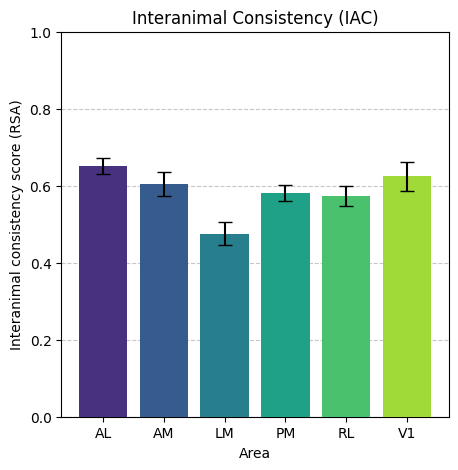

In [3]:
areas = list(iac.keys())
scores = [iac[a] for a in areas]
errors = [iac_sem[a] for a in areas]

# use matplotlib's bar so we can pass yerr directly
x_pos = np.arange(len(areas))
plt.figure(figsize=(5, 5))
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)
plt.bar(x_pos, scores, yerr=errors, capsize=5, color=sns.color_palette("viridis", len(areas)), zorder=3)
plt.xticks(x_pos, areas)
plt.xlabel("Area")
plt.ylabel("Interanimal consistency score (RSA)")
plt.ylim(0, 1)
plt.title("Interanimal Consistency (IAC)")
plt.savefig("./image/iac_scores.jpeg", dpi=300, bbox_inches='tight')

# Model neural predictivity

## loading and normalizing by area

In [4]:
def build_model_dfs_from_pickle(pickle_path: str):

    AREA_NORM = {
        "AL": 0.647716,
        "AM": 0.570069,
        "LM": 0.453128,
        "PM": 0.551936,
        "RL": 0.542426,
        "V1": 0.592209,
    }

    # 1) carico
    with open(pickle_path, "rb") as f:
        layer_scores_by_model: dict[str, pd.DataFrame] = pickle.load(f)

    # 2) unico DF lungo
    long = pd.concat(
        [df.assign(model=m) for m, df in layer_scores_by_model.items()],
        ignore_index=True,
    )
    # sanity
    required = {"area", "layer", "score", "model"}
    missing = required - set(long.columns)
    if missing:
        raise ValueError(f"Mancano colonne: {sorted(missing)}")

    # 3) normalizzazione per area (per riga/specimene)
    norm = pd.Series(AREA_NORM, name="norm_factor")
    long = long.merge(norm, left_on="area", right_index=True, how="left")
    if long["norm_factor"].isna().any():
        miss = long.loc[long["norm_factor"].isna(), "area"].unique().tolist()
        raise ValueError(f"Fattore mancante per aree: {miss}")

    long["score"] = long["score"] / long["norm_factor"]

    long = long.drop(columns="norm_factor")

    # 4) aggregazione: mean + SEM dai punteggi normalizzati
    stats_df = (
        long.groupby(["model", "area", "layer"])["score"]
            .agg(mean_score="mean", sem_score=lambda s: s.sem())
            .reset_index()
            .set_index(["model", "area", "layer"])
            .sort_index()
    )

    # 5) dict per plot_comparison
    model_dfs = {
        m: g[["area", "layer", "mean_score", "sem_score"]]
              .rename(columns={"mean_score": "score", "sem_score": "sem"})
              .reset_index(drop=True)
        for m, g in stats_df.reset_index().groupby("model", sort=False)
    }

    return stats_df, model_dfs

# costruisco model_dfs in un colpo
rsa_score_norm_ml_stats, model_dfs = build_model_dfs_from_pickle("rsa_results.pkl")

## Nayebi style

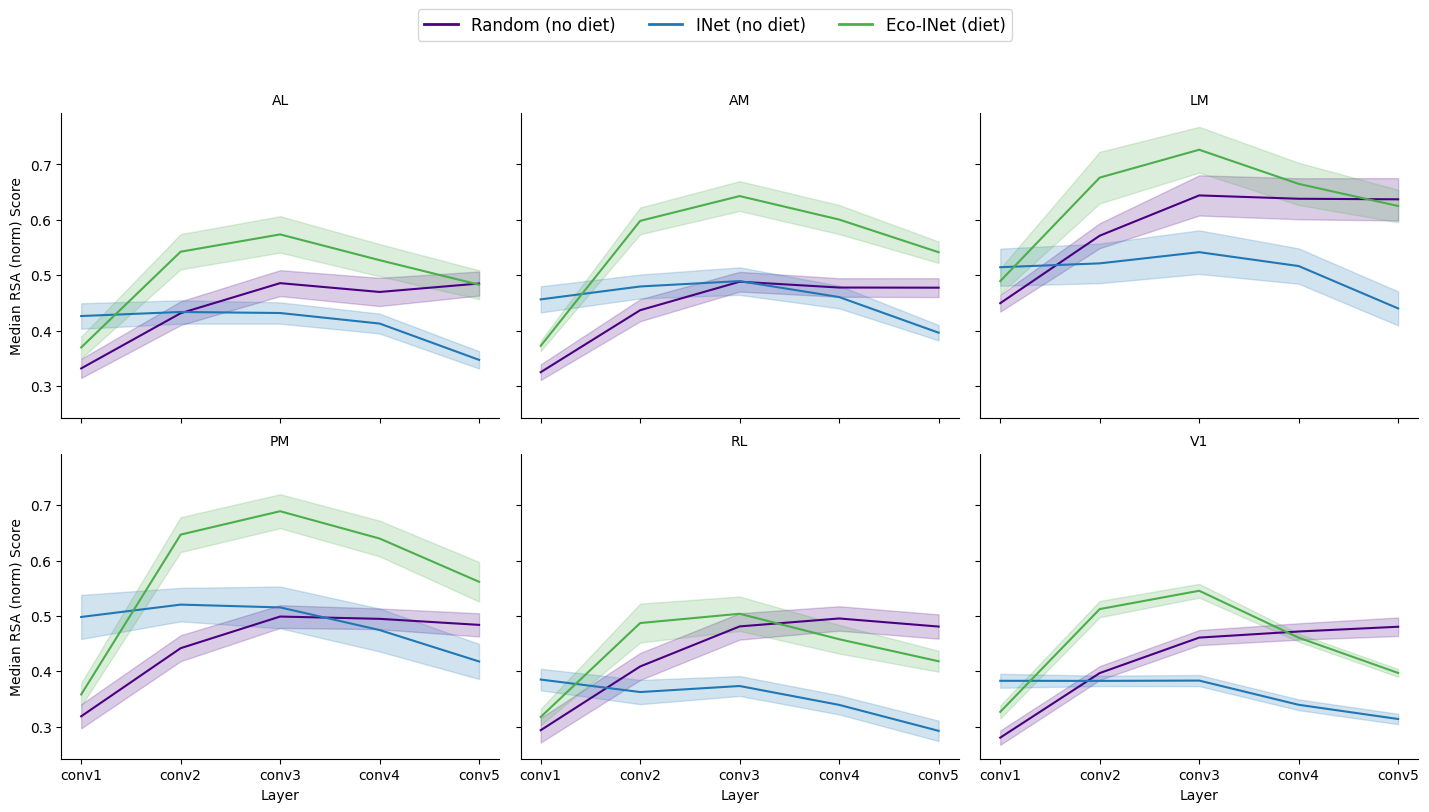

In [5]:
to_plot = {
    "Rand-In"    : model_dfs["Random-no-diet"],
    "INet-In"    : model_dfs["ImageNet-no-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_comparison(to_plot, metric_name="RSA (norm)")
plt.show()

fig.savefig("./image/main-result.jpeg", dpi=300, bbox_inches="tight")


## delta

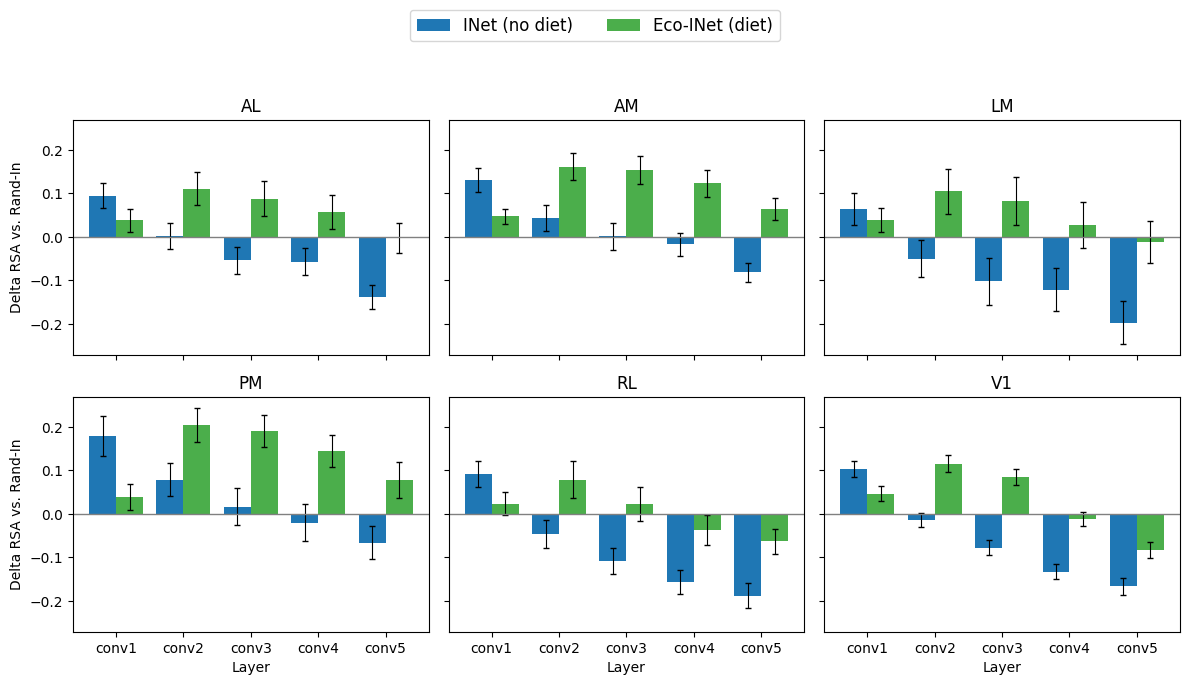

In [6]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("./image/deltas.jpeg", dpi=300, bbox_inches="tight")


## inference

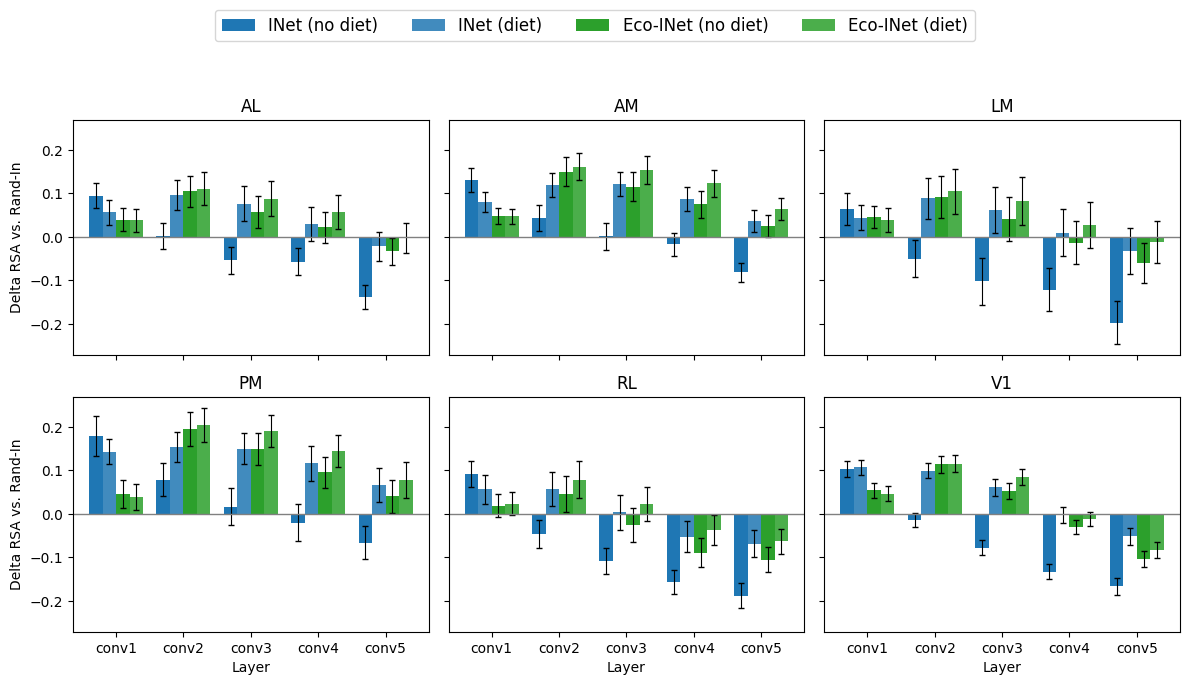

In [7]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Id" : model_dfs["ImageNet-diet"],
    "INet-Td-In" : model_dfs["inet-td-no-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("./image/inference.jpeg", dpi=300, bbox_inches="tight")


## Nayebi diet

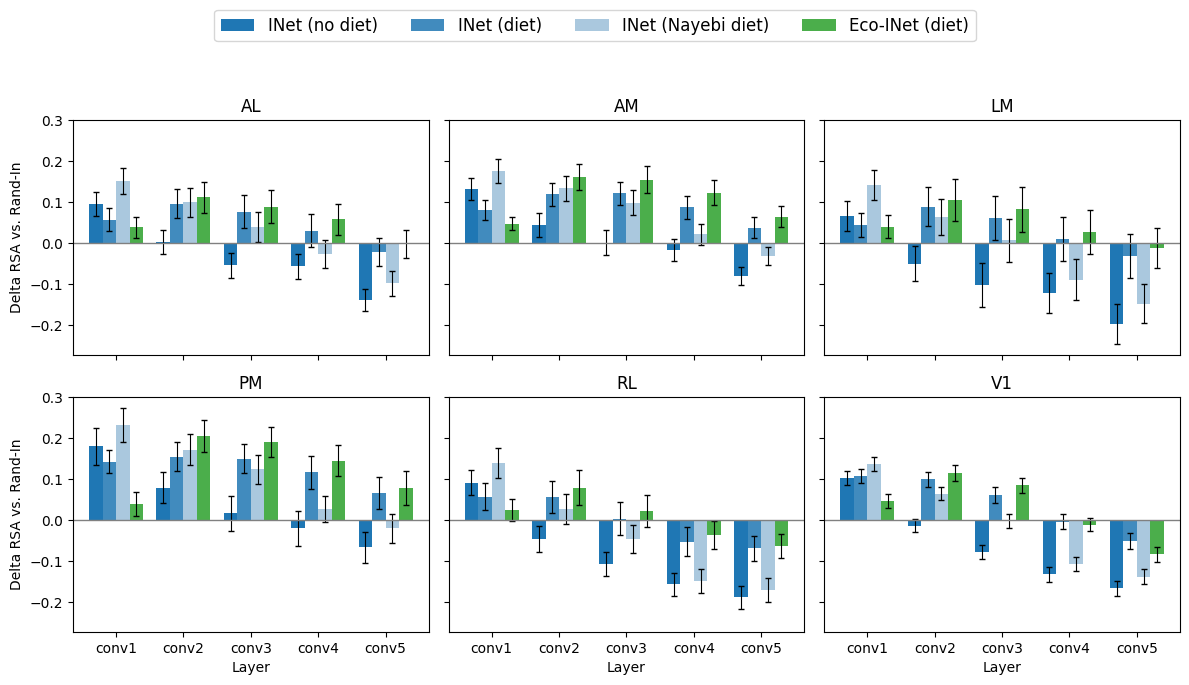

In [8]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Id" : model_dfs["ImageNet-diet"],
    "INet-Iny" : model_dfs["ImageNet-nayebi-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("./image/nayebi-diet.jpeg", dpi=300, bbox_inches="tight")


### Comparison (no blur, no noise)

In [9]:
model_dfs.keys()

dict_keys(['ImageNet-diet', 'ImageNet-diet-no-blur', 'ImageNet-diet-no-noise', 'ImageNet-nayebi-diet', 'ImageNet-no-diet', 'ImageNet-random-diet', 'Random-diet', 'Random-diet-no-blur', 'Random-diet-no-noise', 'Random-nayebi-diet', 'Random-no-diet', 'Random-random-diet', 'inet-td-diet', 'inet-td-diet-no-blur', 'inet-td-diet-no-noise', 'inet-td-nayebi-diet', 'inet-td-no-diet', 'inet-td-random-diet'])

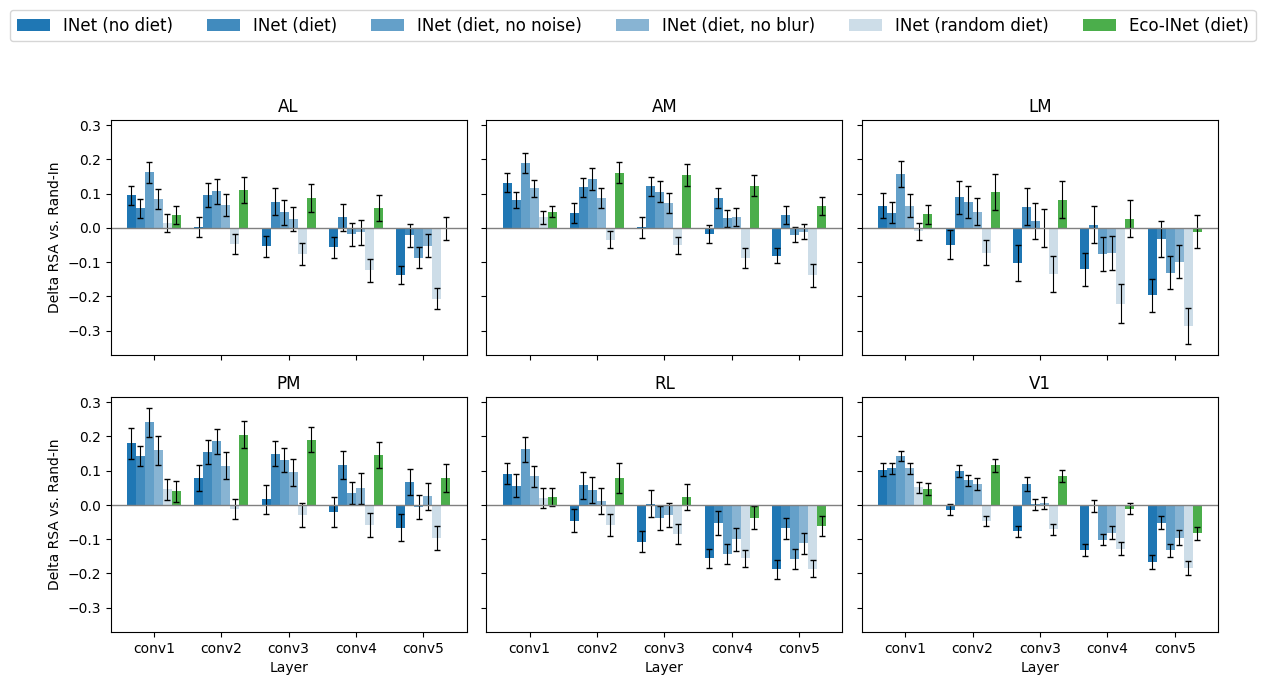

In [10]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Id" : model_dfs["ImageNet-diet"],
    "INet-Idnn" : model_dfs["ImageNet-diet-no-noise"],
    "INet-Idnb" : model_dfs["ImageNet-diet-no-blur"],
    # "INet-Iny" : model_dfs["ImageNet-nayebi-diet"],
    "INet-Ir" : model_dfs["ImageNet-random-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

# fig.savefig("./image/no-noise.jpeg", dpi=300, bbox_inches="tight")


perchè il noise è problematico per la neural similarity in conv1?


Nel layer 1 il segnale low pass (solo blur) matcha bene le caratteristiche corticali del topo, lo si vede guardando a (diet, no noiese) e (Nayebi diet) definita da un downscaling+upscaling. La nostra fa anche meglio perchè è un blur ottimizzado sulle caratteristiche visive del topo. A casa della linearità di conv1, in buona approssimazione visto che è il primo layer, aggiungere il noise va a degradare gli elementi delle RDM con un termine random (diverso per ogni immagine). Il noise sulle immagini si comporta essenzialmente come noise sulle attivazioni di conv1, dunque noise sulla misura. 

\begin{equation}
    x' = x + \eta
\end{equation}

\begin{equation}    
    z^1(x) = \text{ReLU}(W*x+b)
\end{equation}

\begin{equation}    
    z^1(x') = \text{ReLU}(W*(x + \eta)+b) \approx z^1(x) + W*\eta
\end{equation}

\begin{equation}    
    \text{RDM}^{(1)}_{i,j} = 1 - \text{Corr}(z^1(x'_i),  z^1(x'_j))
\end{equation}

e aumentando il rumore $\eta$, diminuisce la correlazione tra i segnali (lineare nel rumore) (see random diet).

Nei layer successivi, la relazione non è più semplicemente lineare ed il rumore viene filtrato/mediato lungo tutta la gerarchia. Quindi da una parte il noise inteso come rumore della misura viene contenuto. Inoltre, quel poco di noise che resta rende le RDM dei layer di AlexNet diventano più simili a quelle biologiche. Una possibile spiegazione è che il noise agisca da regolarizzatore biologico della rete artificiale, nel senso che va a ledere la capacità di AlexNet (trainata su ImageNet) di distinguere immagini che per il topo sono ``simili'' e dunque la geometria delle distanze non è più dominata dai dettagli ma da informazioni di basso livello (ciò che il topo usa).

Nel plot successivo analisi su Nayebi: la dieta di nayebi non è nient'altro che un caso particolare, non ottimizzato, della nostra ma senza noise. La nostra infatti, essendo ottimizzata sulle CSF di Prusky porta risultati migliori su conv1, dove però, per costruzione (linearità) di alexenet, l'aggiunta di noise è deleteria.

Si potrebbe dunque pensare di creare una architettura ad hoc tale da avere conv1 allineato al topo ma robusto al noise e con i layer successivi tali da poter essere regolarizzati dal noise in input.

TODO:

ordine dei risultati:
1. main result e main delta
2. disentanglement dell'inference time
3. disentanglement di blur e noise (con formule e plot mettendo la random diet -> noise 1 è abbastanza grande in modulo tale da mandare a 0 le correlazioni tra stimoli anche a layer profondi)
4. nayebi's proxy


aggiornare poi introduzione ("la nostra dieta agisce da regolarizzatore biologico sui layer (convoluzionali) di alexnet successivi al primo") e conclusioni

## random

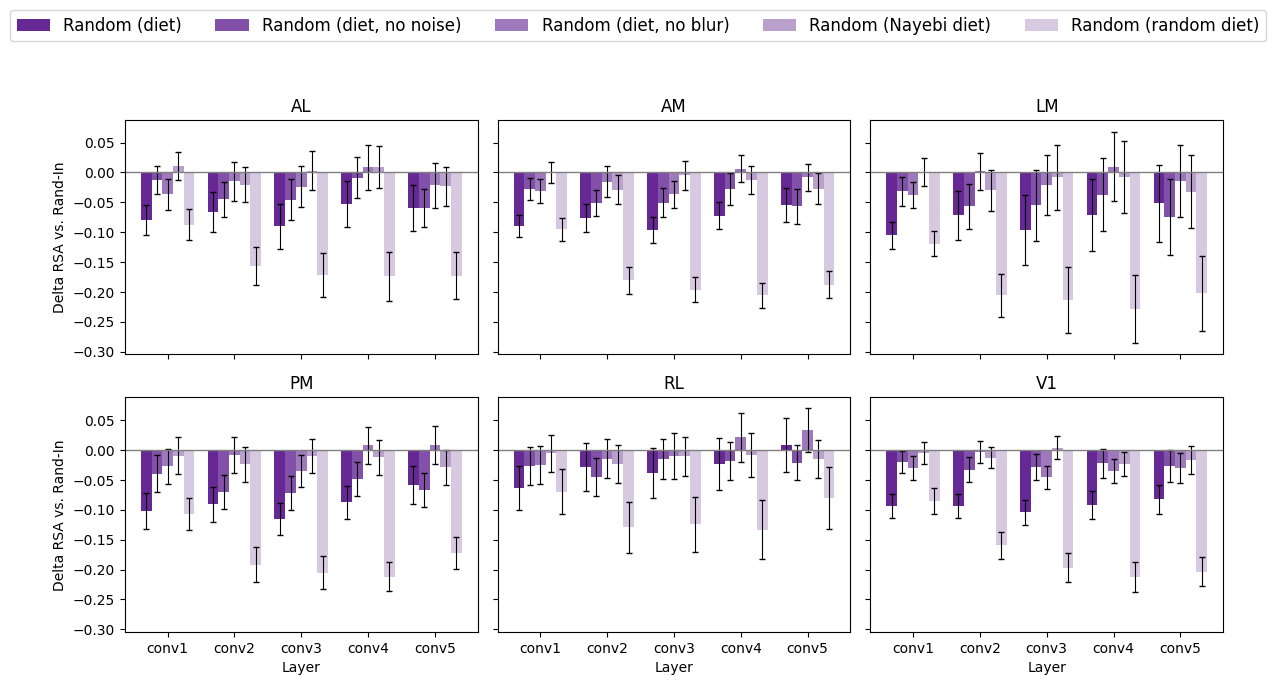

In [11]:
to_plot = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "Rand-Id" : model_dfs["Random-diet"],
    "Rand-Idnn" : model_dfs["Random-diet-no-noise"],
    "Rand-Idnb" : model_dfs["Random-diet-no-blur"],
    "Rand-Iny" : model_dfs["Random-nayebi-diet"],
    "Rand-Ir" : model_dfs["Random-random-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot)
plt.show()
# fig.savefig("./image/random.jpeg", dpi=300, bbox_inches="tight")